TOTALE IMMAGINI = 5821 
*   Bagno = 902
*   Camera letto = 288
*   Cameretta = 1213
*   Cucina = 864
*   Salone = 2553
---
> Train data = 3489
<br>
> Test data = 1745








In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset 
from PIL import Image
from os import path

class ScenesDataset(Dataset):
    """Implementa l'oggetto ScenesDataset che ci permette 
    di caricare le immagini del dataset"""
   
    def __init__(self,base_path,txt_list, transform=None):
        """Input:
        base_path: il path alla cartella contenente le immagini
        txt_list: il path al file di testo contenente la lista delle immagini
        con le relative etichette. Ad esempio train.txt o test.txt.
        transform: implementeremo il dataset in modo che esso supporti le trasformazioni"""
        #conserviamo il path alla cartella contenente le immagini
        self.base_path=base_path
       
        #carichiamo la lista dei file
        #sarà una matrice con n righe (numero di immagini) e 2 colonne (path, etichetta) 
        self.images = np.loadtxt(txt_list,dtype=str,delimiter=',')
        #conserviamo il riferimento alla trasformazione da applicare
        self.transform = transform
  
    def __getitem__(self,index):
        #recuperiamo il path dell'immagine di indice index e la relativa etichetta 
        #f,c = self.images[index]
        #f = path. c = class
        f,c = self.images[index]
    
        #il dataset contiene alcune immagini in scala di grigi
        #convertiamo tutto in RGB per avere delle immagini consistenti
        im = Image.open(path.join(self.base_path,f))

       # print(self.base_path + f)
        #carichiamo l'immagine utilizzando PIL
       # im = Image.open(self.base_path, f)

        #se la trasfromazione è definita, applichiamola all'immagine
        if self.transform is not None: 
          im = self.transform(im)
        
        #convertiamo l'etichetta in un intero
        label = int(c)
        
        #restituiamo un dizionario contenente immagine etichetta
        return im, label
   
    #restituisce il numero di campioni: la lunghezza della lista "images"
    def __len__(self):
        return len(self.images)

Adesso normalizziamo i dati solo per il train. Gli stessi valori verranno usati anche il test

In [0]:
"""
m = np.zeros(3)
for sample in train_data:
    m+=sample['image'].sum(1).sum(1).numpy() #accumuliamo la somma dei pixel canale per canale #dividiamo per il numero di immagini moltiplicato per il numero di pixel

m=m/(len(train_data)*256*256)
#procedura simile per calcolare la deviazione standard
s = np.zeros(3)
for sample in train_data:
    s+=((sample['image']-torch.Tensor(m).view(3,1,1))**2).sum(1).sum(1).numpy() 

s=np.sqrt(s/(len(train_data)*256*256))

print("Medie",m) 
print("Dev.Std.",s)
#output m:[0.37589116 0.34989147 0.33615701] 
#output s:[0.21229402 0.21583879 0.21158814]
"""


In [0]:
#definiamo le transformazioni da applicare alle immagini
from torchvision import transforms 
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.375, 0.349, 0.336], [0.212, 0.215, 0.211])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.375, 0.349, 0.336], [0.212, 0.215, 0.211])
])

In [0]:
from torch.utils.data import DataLoader

train_data = ScenesDataset('/content/drive/My Drive/Progetto Machine Learning/Dataset/immagini','/content/drive/My Drive/Progetto Machine Learning/Dataset/txt/train.txt',transform=train_transform)
validation_data = ScenesDataset('/content/drive/My Drive/Progetto Machine Learning/Dataset/immagini','/content/drive/My Drive/Progetto Machine Learning/Dataset/txt/valid.txt',transform=train_transform)
test_data = ScenesDataset('/content/drive/My Drive/Progetto Machine Learning/Dataset/immagini','/content/drive/My Drive/Progetto Machine Learning/Dataset/txt/test.txt',transform=test_transform)

train_loader = DataLoader(train_data, batch_size=64, num_workers=2, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, num_workers=2)

<class '__main__.ScenesDataset'>


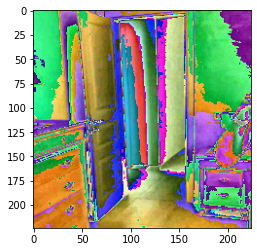

In [0]:
import matplotlib.pyplot as plt
im, lab = train_data[0]
print(type(train_data))
plt.imshow(transforms.ToPILImage()(im))

In [0]:
from torchvision.models import resnet18 
import torch.nn as nn
model = resnet18(pretrained=True)
### adattamento
num_class = 5
model.fc = nn.Linear(512, num_class)
model.num_classes = num_class
###
device= 'cpu'
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = torch.zeros(25,3,224,224).to(device)
model = model.to(device)
out = model(batch) 
print(out.shape)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



torch.Size([25, 5])


In [0]:
pip install torchnet

FASE DI TRAINING

In [0]:
class AverageValueMeter(): 
    def __init__(self):
        self.reset()
    
    def reset(self): 
        self.sum = 0 
        self.num = 0
   
    def add(self, value, num): 
        self.sum += value*num 
        self.num += num
   
    def value(self): 
        try:
          return self.sum/self.num 
        except:
            return None

In [0]:
from os.path import join
from torch.optim import SGD
#from torchnet.meter import AverageValueMeter
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter

def train_classifier(model, train_loader, test_loader, exp_name='experiment', lr=0.001, epochs= 10, momentum=0.9, logdir="/content/drive/My Drive/Progetto Machine Learning/logs/ResNET"):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr, momentum=momentum) 
    #meters
    loss_meter = AverageValueMeter()
    acc_meter = AverageValueMeter()
    #writer
    writer = SummaryWriter(logdir)
    #device
    device = "cuda" if torch.cuda.is_available() else "cpu" 
    model.to(device)
    #definiamo un dizionario contenente i loader di training e test 
    loader = {
            'train' : train_loader,
            'test' : test_loader
        }
    #inizializziamo il global step
    global_step = 0
    #global_step = dict_state['global_step']
    for e in range(epochs):
        #iteriamo tra due modalità: train e test
        for mode in ['train','test']:
            loss_meter.reset(); acc_meter.reset()
            model.train() if mode == 'train' else model.eval()
            with torch.set_grad_enabled(mode=='train'): #abilitiamo i gradienti solo in trainin
                
                for i, batch in enumerate(loader[mode]): 
                    x=batch[0].to(device) #"portiamoli sul device corretto" 
                    y=batch[1].to(device)
                    output = model(x)
                 
                    #aggiorniamo il global_step
                    #conterrà il numero di campioni visti durante il training 
                    n = x.shape[0] #numero di elementi nel batch
                    global_step += n
                    l = criterion(output,y)
                 
                    if mode=='train': 
                        l.backward()
                        optimizer.step() 
                        optimizer.zero_grad()
                    
                    acc = accuracy_score(y.to('cpu'),output.to('cpu').max(1)[1]) 
                    loss_meter.add(l.item(),n)
                    acc_meter.add(acc,n)
                    print("Epoch {e}/{epochs} | {mode} | Loss {loss} - Accuracy {acc}".format(e=e+1, epochs=epochs, mode=mode, loss=str(loss_meter.value()), acc=str(acc_meter.value())))

                  
                    #loggiamo i risultati iterazione per iterazione solo durante il training
                    if mode=='train':
                        writer.add_scalar('loss/train', loss_meter.value(), global_step=global_step)
                        writer.add_scalar('accuracy/train', acc_meter.value(), global_step=global_step) #una volta finita l'epoca (sia nel caso di training che test, loggiamo le stime fin
            writer.add_scalar('loss/' + mode, loss_meter.value(), global_step=global_step) 
            writer.add_scalar('accuracy/' + mode, acc_meter.value(), global_step=global_step)
        torch.save({'state_dict': model.state_dict(), 'global_step': global_step},'%s-%d.pth'%(exp_name,e+1)) 
    return model

# Avvio fase di Training

In [0]:
resnet_dataset_finetuning = train_classifier(model, train_loader,validation_loader, exp_name='resnet_dataset_finetuning', lr = 0.01, epochs = 15)

# Caricamento modello da Drive
#### *ATTENZIONE!*
*AVVIARE LA CELLA SOLO CON IL CORRETTO FINETUNING, SOSTIUENDO X CON L'ULTIMO DISPONIBILE*

In [0]:
import torch 
dict_state = torch.load('/content/drive/My Drive/Progetto Machine Learning/logs/ResNET/resnet_dataset_finetuning-15.pth')
model.load_state_dict(dict_state['state_dict'])
model.eval()
print(model)

# Accuracy del modello su Training e Test set

In [0]:
def test_classifier(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    predictions, labels = [], []
    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        output = model(x)
        preds = output.to('cpu').max(1)[1].numpy() 
        labs = y.to('cpu').numpy() 
        predictions.extend(list(preds)) 
        labels.extend(list(labs))
    return np.array(predictions), np.array(labels)

In [0]:
resnet_indoor_predictions_train, indoor_labels_train = test_classifier(model, train_loader)
resnet_indoor_predictions_test, indoor_labels_test = test_classifier(model, test_loader)

print("Accuarcy di training: %0.4f"% accuracy_score(indoor_labels_train, resnet_indoor_predictions_train))
print("Accuarcy di test: %0.4f"% accuracy_score(indoor_labels_test, resnet_indoor_predictions_test))

Accuarcy di training: 0.9986
Accuarcy di test: 0.9926


## Test su singola immagine

In [0]:
from PIL import Image
img = Image.open("/content/drive/My Drive/Progetto Machine Learning/Dataset/immagini/bagno/bagno03391.png") #immagine di test
img_t = test_transform(img)
batch_t = torch.unsqueeze(img_t, 0)
model.eval()
out = model(batch_t)

#memorizziamo le labels presenti nel file classes.txt
with open('/content/drive/My Drive/Progetto Machine Learning/Dataset/txt/classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

#dobbiamo determinare l'indice dove si verifica il punteggio massimo nel vettore out. 
#Useremo questo indice per scoprire la previsione.
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item())

0,bagno 100.0


# Esportazione modello in formato .pt

In [0]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("/content/model.pt")